# Load the necessities

In [1]:
import os
import torch
import numpy as np
import schnetpack as spk

import numpy as np
import matplotlib.pyplot as plt
from ase.units import kcal, mol

qm9tut = './data'

if not os.path.exists('./data'):
    os.makedirs(qm9tut)

from schnetpack.datasets import QM9_energy

In [2]:
# %rm ./data/split_new_hybrid_energy.npz

In [3]:
qm9data = QM9_energy('./data/qm9_bugger_energy.db', load_only=[QM9_energy.energy], download=True)

train, val, test = spk.train_test_split(
        data=qm9data,
        num_train=5000,
        num_val=100,
        split_file=os.path.join(qm9tut, "split_qm9_bugger_energy.npz"),
    )

In [4]:
train_loader = spk.AtomsLoader(train, batch_size=32, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=32)

atomrefs = {QM9_energy.energy: np.array([qm9data[i][QM9_energy.energy].item() for i in range(10)], dtype=float).reshape(-1,1)}

means, stddevs = train_loader.get_statistics(
    QM9_energy.energy, divide_by_atoms=True, single_atom_ref=atomrefs
)
print('Mean:', means[QM9_energy.energy])
print('Std. dev.:', stddevs[QM9_energy.energy])

Mean: tensor([511.0354])
Std. dev.: tensor([89.0396])


In [5]:
schnet = spk.representation.SchNet(
    n_atom_basis=64, n_filters=64, n_gaussians=48, n_interactions=32,
    cutoff=4., cutoff_network=spk.nn.cutoff.CosineCutoff
)
output_energy = spk.atomistic.Atomwise(n_in=64,
                                       atomref=atomrefs[QM9_energy.energy],
                                       property=QM9_energy.energy,
                                       mean=means[QM9_energy.energy],
                                       stddev=stddevs[QM9_energy.energy])
# vanilla_model = spk.AtomisticModel(representation=schnet, output_modules=output_energy)
converter = spk.data.AtomsConverter(device="cuda:3")

# Train

In [6]:
model = spk.AtomisticModel(representation=schnet, output_modules=output_energy)

In [12]:
from torch.optim import Adam
# from adamAsynch import Adam

# loss function
def mse_loss(batch, result):
    diff = batch[QM9_energy.energy]-result[QM9_energy.energy]
    err_sq = torch.mean(diff ** 2)
    return err_sq

# build optimizer
optimizer = Adam(model.parameters(), lr=5e-4)

In [13]:
# %rm -r ./data/checkpoints
# %rm -r ./data/log.csv

import schnetpack.train as trn

loss = trn.build_mse_loss([QM9_energy.energy])

metrics = [spk.metrics.MeanAbsoluteError(QM9_energy.energy)]
hooks = [
    trn.CSVHook(log_path=qm9tut, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.9, min_lr=1e-5,
        stop_after_min=True
    )
]

trainer = trn.Trainer(
    model_path=qm9tut,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [15]:
device = "cuda:3" # change to 'cpu' if gpu is not available
n_epochs = 512 # takes about 10 min on a notebook GPU. reduces for playing around
trainer.train(device=device, n_epochs=n_epochs)

 27%|██████████████████████████████████▌                                                                                             | 138/512 [56:00<2:31:46, 24.35s/it]


KeyboardInterrupt: 

In [16]:
results = np.loadtxt(os.path.join(qm9tut, 'log.csv'), skiprows=1, delimiter=',')
time = results[:,0]-results[0,0]
learning_rate, train_loss, val_loss, val_mae = results[:,1], results[:,2], results[:,3], results[:,4]

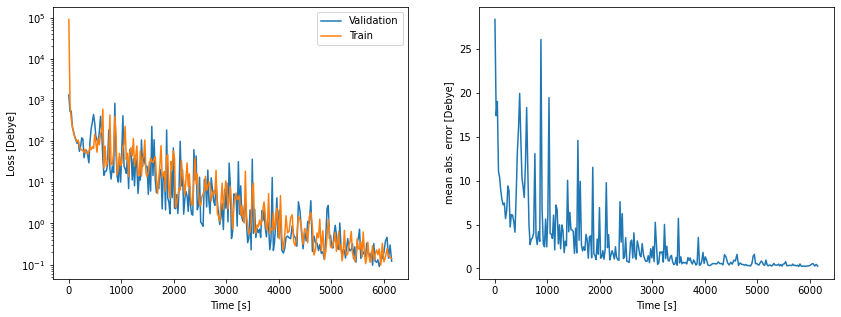

In [17]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, val_loss, label='Validation')
plt.plot(time, train_loss, label='Train')
plt.yscale('log')
plt.ylabel('Loss [Debye]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae)
plt.ylabel('mean abs. error [Debye]')
plt.xlabel('Time [s]')
plt.show()

In [18]:
# torch.save(model.state_dict(), "./data/20221210_qm9_bugger_energy_new.pt")
# %mv ./data/checkpoints ./data/checkpoints_20221210_qm9_bugger_energy_new
# %mv ./data/log.csv ./data/log_20221210_qm9_bugger_energy_new.csv

# Tune with BO

In [7]:
model = spk.AtomisticModel(representation=schnet, output_modules=output_energy)
model.load_state_dict(torch.load(os.path.join(qm9tut, '20221209_qm9_bugger_energy.pt')))

<All keys matched successfully>

In [15]:
import torch.optim
from adamAsynch import Adam as adamBO
# build optimizer
optimizer = adamBO(model.parameters(), lr=5e-3)

In [16]:
%rm -r ./data/checkpoints
%rm -r ./data/log.csv

import schnetpack.train as trn

loss = trn.build_mse_loss([QM9_energy.energy])

metrics = [spk.metrics.MeanAbsoluteError(QM9_energy.energy)]
hooks = [
    trn.CSVHook(log_path=qm9tut, metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.9, min_lr=1e-6,
        stop_after_min=True
    )
]

trainer = trn.TrainerAsynch(
    model_path=qm9tut,
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [18]:
device = "cuda:3" # change to 'cpu' if gpu is not available
n_epochs = 100 # takes about 10 min on a notebook GPU. reduces for playing around
trainer.train(device=device, n_epochs=n_epochs)

# Check tuned accuracy

In [6]:
import os
import torch
import numpy as np
import schnetpack as spk
from schnetpack.datasets import QM9_energy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from ase.units import kcal, mol

In [7]:
def get_loss(_model, _database_name="qm9_bugger_energy", _num=500):
    this_database = QM9_energy('./data/{}.db'.format(_database_name), load_only=[QM9_energy.energy], download=True)
    this_train, this_val, this_test = spk.train_test_split(data = this_database,
                                            num_train = 500, num_val = 1,
                                            split_file = os.path.join(qm9tut, "split_{}.npz".format(_database_name)))

    preds, truths = [], []
    for i in tqdm(range(_num), ncols=50):
        at, props = this_train.get_properties(idx=i)
        inputs = converter(at)
        truths.append(props[QM9_energy.energy][0].item())
        pred = _model(inputs)
        preds.append(pred[QM9_energy.energy][0].item())

    plt.figure(figsize=(4,4))
    plt.scatter(truths, preds)
    plt.xlim(min(truths), max(truths))
    plt.ylim(min(truths), max(truths))
    plt.show()
    
    return truths, preds, ((np.array(truths)-np.array(preds))**2).sum()/_num

In [8]:
model = spk.AtomisticModel(representation=schnet, output_modules=output_energy).to("cuda:3")
model.load_state_dict(torch.load(os.path.join(qm9tut, '20221209_qm9_bugger_energy.pt')))
model.eval()

AtomisticModel(
  (representation): SchNet(
    (embedding): Embedding(100, 64, padding_idx=0)
    (distances): AtomDistances()
    (distance_expansion): GaussianSmearing()
    (interactions): ModuleList(
      (0): SchNetInteraction(
        (filter_network): Sequential(
          (0): Dense(in_features=48, out_features=64, bias=True)
          (1): Dense(in_features=64, out_features=64, bias=True)
        )
        (cutoff_network): CosineCutoff()
        (cfconv): CFConv(
          (in2f): Dense(in_features=64, out_features=64, bias=False)
          (f2out): Dense(in_features=64, out_features=64, bias=True)
          (filter_network): Sequential(
            (0): Dense(in_features=48, out_features=64, bias=True)
            (1): Dense(in_features=64, out_features=64, bias=True)
          )
          (cutoff_network): CosineCutoff()
          (agg): Aggregate()
        )
        (dense): Dense(in_features=64, out_features=64, bias=True)
      )
      (1): SchNetInteraction(
        (

In [9]:
qm9data = QM9_energy('./data/BindingDB_energy.db', load_only=[QM9_energy.energy], download=True)

train, val, test = spk.train_test_split(
        data=qm9data,
        num_train=500,
        num_val=10,
        split_file=os.path.join(qm9tut, "split_BindingDB_energy.npz"),
    )

100%|█████████████████████████████████████████| 500/500 [00:07<00:00, 68.51it/s]


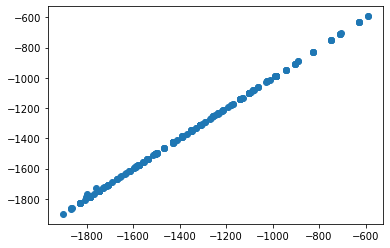

In [10]:
preds, truths = [], []
# for i in tqdm(range(len(test))):
for i in tqdm(range(500), ncols=80):
    at, props = test.get_properties(idx=i)

    inputs = converter(at)
#     print(inputs)
    elements = set(inputs["_atomic_numbers"].cpu().tolist()[0])
    if elements - set([1, 6, 7, 8]) != set():
        continue
    
    truths.append(props[QM9_energy.energy][0])

    pred = model(inputs)
    preds.append(pred[QM9_energy.energy][0].item())
plt.scatter(truths, preds)

In [11]:
qm9data = QM9_energy('./data/BindingDB_energy.db', load_only=[QM9_energy.energy], download=True)

train, val, test = spk.train_test_split(
        data=qm9data,
        num_train=500,
        num_val=10,
        split_file=os.path.join(qm9tut, "split_BindingDB_energy.npz"),
    )

100%|█████████████████████████████████████████| 500/500 [00:06<00:00, 74.65it/s]


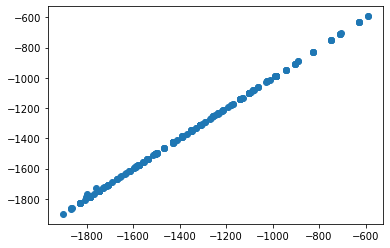

In [12]:
preds, truths = [], []
# for i in tqdm(range(len(test))):
for i in tqdm(range(500), ncols=80):
    at, props = test.get_properties(idx=i)

    inputs = converter(at)
#     print(inputs)
    elements = set(inputs["_atomic_numbers"].cpu().tolist()[0])
    if elements - set([1, 6, 7, 8]) != set():
        continue
    
    truths.append(props[QM9_energy.energy][0])

    pred = model(inputs)
    preds.append(pred[QM9_energy.energy][0].item())
plt.scatter(truths, preds)

In [13]:
qm9data = QM9_energy('./data/ChemBL_energy.db', load_only=[QM9_energy.energy], download=True)

train, val, test = spk.train_test_split(
        data=qm9data,
        num_train=500,
        num_val=10,
        split_file=os.path.join(qm9tut, "split_ChemBL_energy.npz"),
    )

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 57.21it/s]


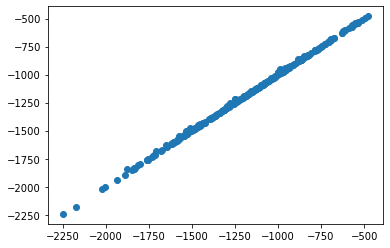

In [14]:
preds, truths = [], []
# for i in tqdm(range(len(test))):
for i in tqdm(range(500), ncols=80):
    at, props = test.get_properties(idx=i)

    inputs = converter(at)
#     print(inputs)
    elements = set(inputs["_atomic_numbers"].cpu().tolist()[0])
    if elements - set([1, 6, 7, 8]) != set():
        continue
    
    truths.append(props[QM9_energy.energy][0])

    pred = model(inputs)
    preds.append(pred[QM9_energy.energy][0].item())
plt.scatter(truths, preds)